In [1]:
# coding=gbk
import os

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance

import matplotlib.pyplot as plt
from model import Model

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 20)
pd.set_option('precision', 2)

In [2]:
columns = [f'HE{i:02d}' for i in range(1, 25)]


def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.weekofyear

    X = df[['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year', 'day_of_month', 'week_of_year']]
    if label:
        y = df[label]
        return X, y
    return X

In [3]:
def read_data(data_file, sheet_names) -> pd.DataFrame:
    def get_data_per_sheet(sheet_name):
        df = pd.read_excel(data_file, parse_dates=['DATE'], index_col=[0], usecols=['DATE', *columns],
                           sheet_name=sheet_name)

        data = pd.DataFrame()
        for index, row in df.iterrows():
            d = [getattr(row, c) for c in columns]
            t = [pd.to_datetime(index.strftime('%Y-%m-%d') + f' {i - 1:02d}:00:00') for i in range(1, 25)]
            dd = pd.DataFrame(index=[index]).from_dict({'value': d, 'DATE': t})
            dd.set_index('DATE', inplace=True)
            if len(data):
                data = pd.concat([data, dd])
            else:
                data = dd

        return data

    data = get_data_per_sheet(sheet_names[0])
    for sheet_name in sheet_names[1:]:
        data = pd.concat([data, get_data_per_sheet(sheet_name)])

    return data

In [4]:
def get_data(data_path) -> pd.DataFrame:
    if not os.path.exists(data_path):
        sheet_names = list(map(int, data_path[:-5].split('_')[1:]))
        data_name = data_path.split('_')[0]

        if data_name == 'data':

            data2014 = read_data('2014PJM数据.xls', sheet_names)
            data2015 = read_data('2015PJM数据.xls', sheet_names)
            data2016 = read_data('2016PJM数据.xls', sheet_names)

            data = pd.concat([data2014, data2015, data2016])
        else:
            data = read_data(f'{data_name}PJM数据.xls', sheet_names)

        data.to_excel(data_path)

    else:
        data = pd.read_excel(data_path, index_col=[0], parse_dates=['DATE'])

    return data

In [5]:
data_path = 'pjme_data.csv'
data = pd.read_csv(data_path,index_col=[0],parse_dates=['DATE'])

In [6]:
sorted(set(data.index.to_list()))

[Timestamp('2002-04-01 01:00:00'),
 Timestamp('2002-04-01 02:00:00'),
 Timestamp('2002-04-01 03:00:00'),
 Timestamp('2002-04-01 04:00:00'),
 Timestamp('2002-04-01 05:00:00'),
 Timestamp('2002-04-01 06:00:00'),
 Timestamp('2002-04-01 07:00:00'),
 Timestamp('2002-04-01 08:00:00'),
 Timestamp('2002-04-01 09:00:00'),
 Timestamp('2002-04-01 10:00:00'),
 Timestamp('2002-04-01 11:00:00'),
 Timestamp('2002-04-01 12:00:00'),
 Timestamp('2002-04-01 13:00:00'),
 Timestamp('2002-04-01 14:00:00'),
 Timestamp('2002-04-01 15:00:00'),
 Timestamp('2002-04-01 16:00:00'),
 Timestamp('2002-04-01 17:00:00'),
 Timestamp('2002-04-01 18:00:00'),
 Timestamp('2002-04-01 19:00:00'),
 Timestamp('2002-04-01 20:00:00'),
 Timestamp('2002-04-01 21:00:00'),
 Timestamp('2002-04-01 22:00:00'),
 Timestamp('2002-04-01 23:00:00'),
 Timestamp('2002-04-02 00:00:00'),
 Timestamp('2002-04-02 01:00:00'),
 Timestamp('2002-04-02 02:00:00'),
 Timestamp('2002-04-02 03:00:00'),
 Timestamp('2002-04-02 04:00:00'),
 Timestamp('2002-04-

In [7]:
split_ratio = 0.95
split_index = int(len(data) * split_ratio)
split_date = data.iloc[split_index].name
train_data = data.iloc[:split_index].copy()
test_data = data.iloc[split_index:].copy()
print(f'split_date={split_date}, len(train_data)={len(train_data)},len(test_data)={len(test_data)}')

split_date=2017-03-26 14:00:00, len(train_data)=136045,len(test_data)=7161


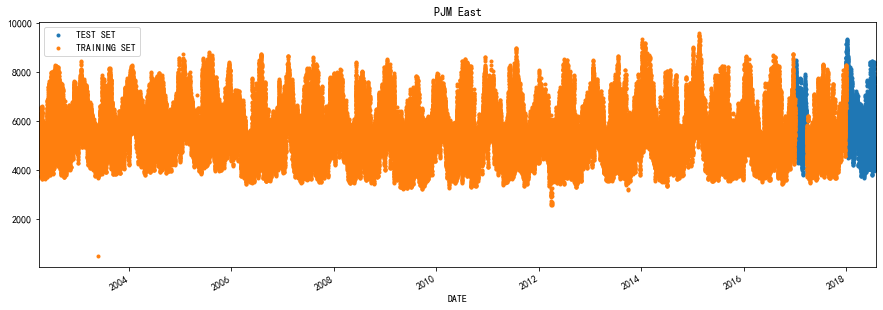

In [8]:
_ = test_data \
    .rename(columns={'value': 'TEST SET'}) \
    .join(train_data.rename(columns={'value': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15, 5), title='PJM East', style='.')
plt.show()

In [9]:
# 训练集
X_train, y_train = create_features(train_data, label='value')
# 测试集
X_test, y_test = create_features(test_data, label='value')
# 模型

In [10]:
# 模型
reg = Model(n_estimators=10000,args=None)
# 训练
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=100, verbose=True)

[0]	validation_0-rmse:3994.16260	validation_1-rmse:4203.09228
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:2826.08911	validation_1-rmse:3010.22168
[2]	validation_0-rmse:2018.54053	validation_1-rmse:2182.21606
[3]	validation_0-rmse:1462.82727	validation_1-rmse:1632.62378
[4]	validation_0-rmse:1090.15723	validation_1-rmse:1282.51257
[5]	validation_0-rmse:843.02887	validation_1-rmse:1062.72937
[6]	validation_0-rmse:686.28003	validation_1-rmse:933.88507
[7]	validation_0-rmse:593.88983	validation_1-rmse:859.83569
[8]	validation_0-rmse:537.64154	validation_1-rmse:820.40301
[9]	validation_0-rmse:505.88089	validation_1-rmse:794.30402
[10]	validation_0-rmse:487.34753	validation_1-rmse:781.08594
[11]	validation_0-rmse:470.29657	validation_1-rmse:782.22797
[12]	validation_0-rmse:453.52744	validation_1-rmse:774.93268
[13]	validation_0-rmse:449.53867	validation_1-

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

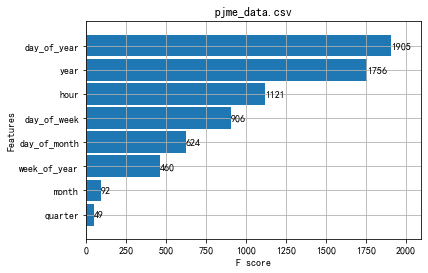

In [11]:
# 分析重要程度
_ = plot_importance(reg, height=0.9, title=data_path)
plt.show()

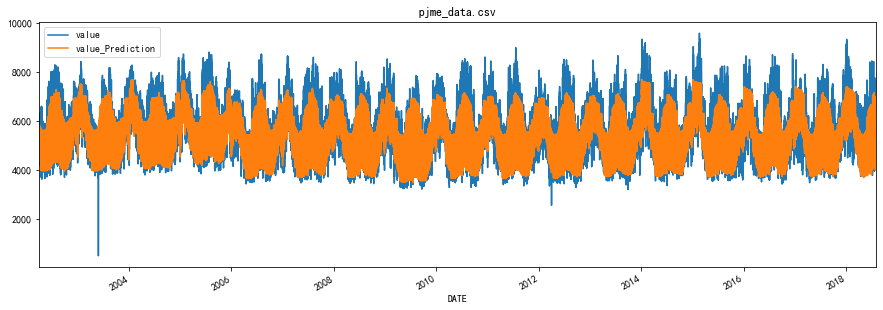

In [12]:
# 预测结果
test_data['value_Prediction'] = reg.predict(X_test)
train_data['value_Prediction'] = reg.predict(X_train)
pjme_all = pd.concat([test_data, train_data], sort=False)
_ = pjme_all[['value', 'value_Prediction']].plot(figsize=(15, 5))
plt.title(data_path)
plt.show()

In [15]:
# 指定日期范围内画出预测结果与真实结果作对比
def plot_predict_days(lower, upper):
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    _ = pjme_all[['value_Prediction', 'value']].plot(ax=ax,
                                                     style=['-', '.'])
    ax.set_xbound(lower=lower, upper=upper)
    # ax.set_ylim(0, 60000)
    plot = plt.suptitle('Forecast vs Actuals')
    plt.show()

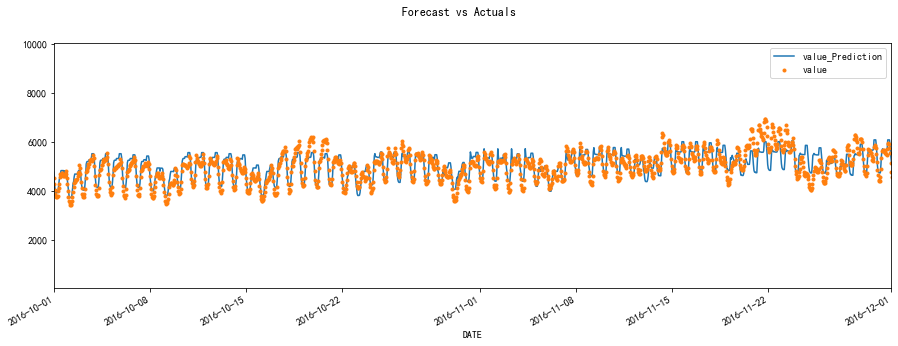

In [16]:
plot_predict_days(lower='10-01-2016', upper='12-01-2016')

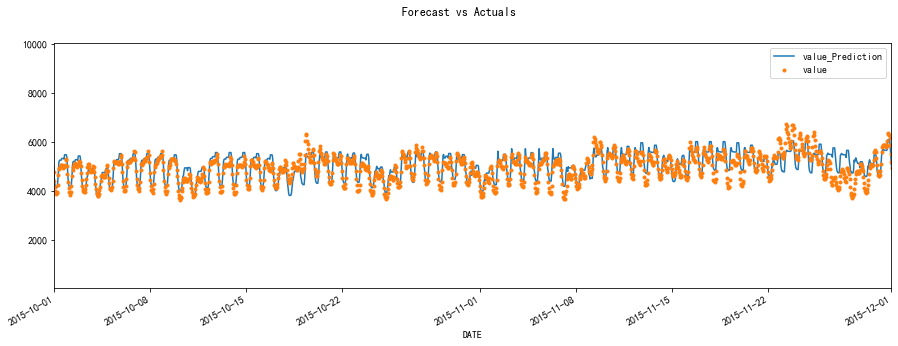

In [17]:
plot_predict_days(lower='10-01-2015', upper='12-01-2015')

In [18]:
# 评估MSE
print(mean_squared_error(y_true=test_data['value'],
                         y_pred=test_data['value_Prediction']))

597574.7760154658


In [19]:
# 评估MAE
print(mean_absolute_error(y_true=test_data['value'],
                          y_pred=test_data['value_Prediction']))

595.3851615139732


In [20]:
# 评估MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print(mean_absolute_percentage_error(y_true=test_data['value'],
                                     y_pred=test_data['value_Prediction']))

9.967517175918461


In [21]:
# 最好的和最坏的结果
test_data['error'] = test_data['value'] - test_data['value_Prediction']
test_data['abs_error'] = test_data['error'].apply(np.abs)
error_by_day = test_data.groupby(['year', 'month', 'day_of_month']) \
    .mean()[['value', 'value_Prediction', 'error', 'abs_error']]

In [22]:
# 最坏的前十天
print(error_by_day.sort_values('abs_error', ascending=False).head(10))

                           value  value_Prediction    error  abs_error
year month day_of_month                                               
2018 1     6             8579.38           5925.60  2653.78    2653.78
           7             8067.04           5693.29  2373.75    2373.75
           5             8794.58           6506.18  2288.41    2288.41
2017 1     8             7658.50           5736.78  1921.72    1921.72
2018 1     1             7740.52           5924.31  1816.21    1816.21
2017 3     15            7282.92           5478.05  1804.87    1804.87
2018 1     2             8044.83           6385.45  1659.38    1659.38
2017 2     24            4780.62           6351.41 -1570.78    1570.78
     1     7             7358.17           5913.67  1444.49    1444.49
2018 1     14            7329.54           5893.44  1436.10    1436.10


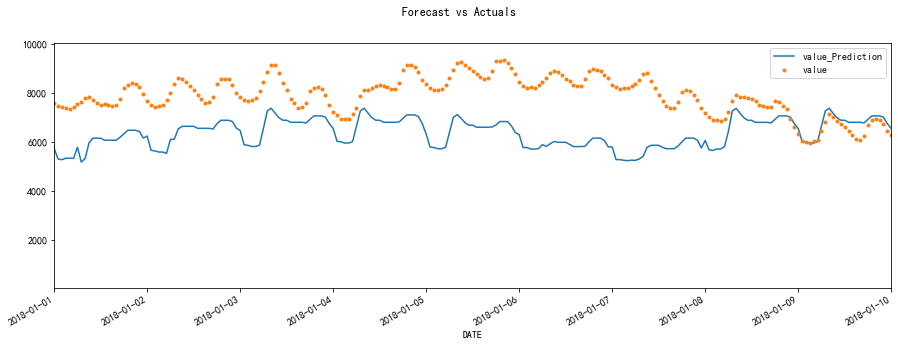

In [23]:
plot_predict_days(lower='01-01-2018', upper='01-10-2018')

In [24]:
# 最好的前十天
print(error_by_day.sort_values('abs_error', ascending=True).head(10))

                           value  value_Prediction  error  abs_error
year month day_of_month                                             
2018 5     6             4355.08           4377.29 -22.21      61.25
           7             4929.42           4925.82   3.60      70.95
           5             4537.71           4482.93  54.78      88.94
     4     13            4934.38           4944.04  -9.67      90.99
     7     23            5900.04           5869.23  30.81      95.75
2017 2     2             6218.79           6295.11 -76.32     112.10
2018 4     24            5100.38           5042.67  57.70     115.49
     1     25            6727.12           6690.95  36.18     125.70
2017 2     5             5889.88           5901.07 -11.19     127.80
2018 4     15            4468.33           4465.93   2.41     129.17


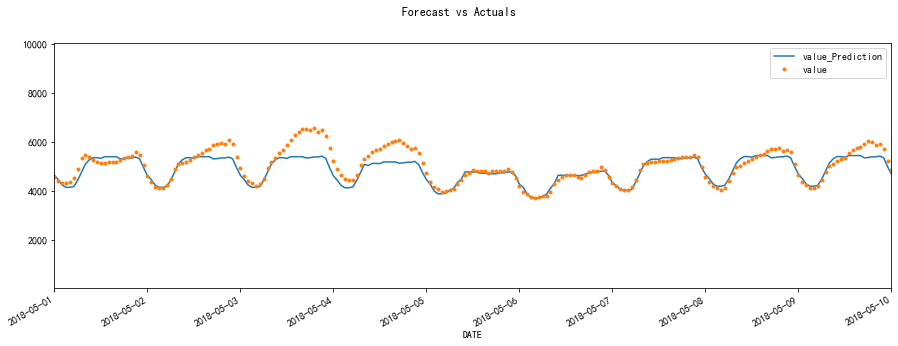

In [25]:
plot_predict_days(lower='05-1-2018', upper='05-10-2018')

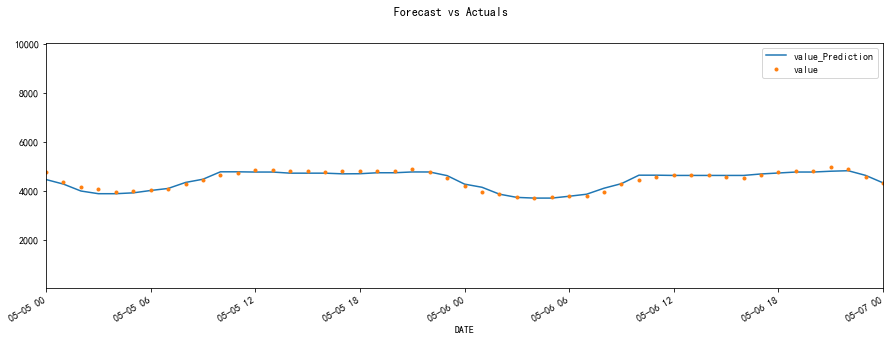

In [27]:
plot_predict_days(lower='05-5-2018', upper='05-7-2018')